# Global adaptive time-stepping for a locally compressed monolayer due to a single proliferation event

# Looking at eigenvalues and eigenvectors

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
separation = 0.3 # initial separation between daughter cells

dim = 2

seed=67
npr.seed(seed)

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], 0.0, proliferating=False) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, move cell there and add second daughter cells
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    
    # get division direction
    random_angle = 2.0 * np.pi * npr.rand()
    division_direction = np.array([np.cos(random_angle), np.sin(random_angle)])
    
    # update positions
    updated_position_parent = coords - 0.5 * separation * division_direction
    sheet[m].position = updated_position_parent   

    position_daughter = coords + 0.5 * separation * division_direction    
    
    # add daughter cell
    next_cell_index = len(sheet)
    daughter_cell = cl.Cell(next_cell_index, position_daughter, birthtime=0.0, proliferating=False)
    sheet.append(daughter_cell)
        
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

In [7]:
# plot function
# eigenvector must contain eigenvector corresponding to a single eigenvalue
def plot_eigenvector_on_population(cell_list, eigenvector, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    eigenvector = eigenvector.reshape((n_cells, -1))
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
        plt.plot([cell_list[i].position[0], cell_list[i].position[0] + eigenvector[i, 0]], [cell_list[i].position[1],cell_list[i].position[1]+eigenvector[i,1]])
    plt.show()

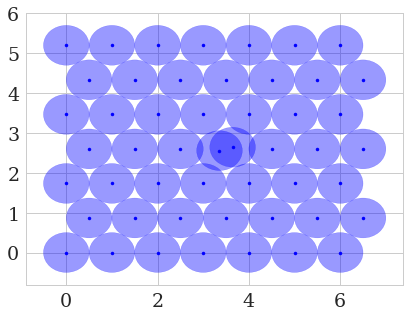

In [8]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

## Cubic force

In [9]:
force = 'cubic'
tf = 60.0
t_data = [0.0,tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,50*dim, 50*dim), order='F')




Nothing to delete.
Nothing to delete.
-61.223453951374324
-57.21179851018692
-53.81021179834026
-50.8484254761764
-48.25180381521747
-45.89891555344669
-43.80049814187227
-41.94546193852645
-40.24844388958268
-38.664773816893685
-37.17095921073358
-35.74413129615268
-34.361085206564624
-32.997516753650046
-31.628026779913533
-30.22891531571802
-28.80662472187163
-27.60656796687914
-26.538720780134526
-25.574774721542166
-24.69617980649887
-23.894759041172463
-23.165474371705358
-22.49540894282291
-21.881817185624197
-21.322349713438616
-20.812558200798158
-20.375312953604727
-20.06237697468833
-19.82562650585742
-19.642845507511844
-19.499500947555195
-19.38637916493379
-19.295721549957047
-19.220935537231828
-19.15872840393524
-19.106512051494597
-19.062721367765505
-19.025878011337657
-18.99515206343295
-18.969563530882823
-18.948646439579953
-18.931682240422774
-18.91840418030091
-18.908244262398544
-18.901053992311454
-18.896358779716834
-18.894085464757623
-18.89382134168191
-18.8

-19.71719209222074
-19.7171730915596
-19.71707019349566


In [10]:
gg_estimates = np.loadtxt('geshgorin'+filename_ending['cubic']+'.txt')

In [26]:
eigenvalues_cubic[-1,:]

array([-1.36055048e+01, -9.88623569e+00, -9.27186255e+00, -9.02215123e+00,
       -7.77787086e+00, -7.67440422e+00, -7.53406667e+00, -7.46836379e+00,
       -7.12249521e+00, -6.95407043e+00, -6.92212570e+00, -6.80391369e+00,
       -6.77454748e+00, -6.59036777e+00, -6.52284634e+00, -6.45513587e+00,
       -6.37073164e+00, -6.20617729e+00, -5.99228168e+00, -5.97101425e+00,
       -5.82830044e+00, -5.67961350e+00, -5.66996070e+00, -5.55200141e+00,
       -5.42526586e+00, -5.18357702e+00, -5.04344470e+00, -4.98682803e+00,
       -4.85825653e+00, -4.84640347e+00, -4.74159258e+00, -4.58067282e+00,
       -4.47168272e+00, -4.28190362e+00, -4.19265672e+00, -4.11515782e+00,
       -4.08763463e+00, -3.94613222e+00, -3.88780787e+00, -3.72992879e+00,
       -3.53826167e+00, -3.49759118e+00, -3.37408137e+00, -3.23886695e+00,
       -3.20527667e+00, -3.11821419e+00, -2.99382401e+00, -2.95371816e+00,
       -2.78686090e+00, -2.74199775e+00, -2.67110912e+00, -2.61163284e+00,
       -2.59019685e+00, -

Text(0.5, 0, 'Time')

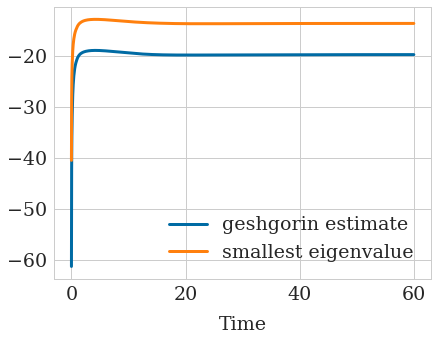

In [22]:
plt.plot(ts[1:], gg_estimates, label='geshgorin estimate')
plt.plot(ts[1:], eigenvalues_cubic[:,0], label='smallest eigenvalue')
plt.legend()
plt.xlabel('Time')

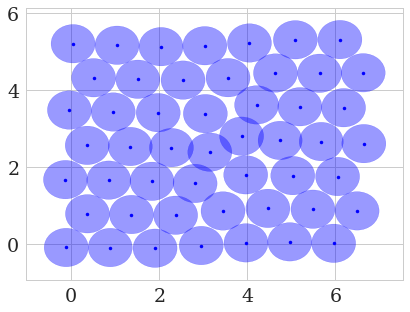

In [23]:
plot_population(history[-1])

### Count number of negative, zero and positive eigenvalues

In [11]:
eigenvalues_cubic.shape

(427, 100)

In [12]:
np.count_nonzero(np.isclose(eigenvalues_cubic, 0, atol=0.00000001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [13]:
np.count_nonzero(eigenvalues_cubic > 0.00000001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
eigenvalues_cubic[-1,:]

array([-1.36055048e+01, -9.88623569e+00, -9.27186255e+00, -9.02215123e+00,
       -7.77787086e+00, -7.67440422e+00, -7.53406667e+00, -7.46836379e+00,
       -7.12249521e+00, -6.95407043e+00, -6.92212570e+00, -6.80391369e+00,
       -6.77454748e+00, -6.59036777e+00, -6.52284634e+00, -6.45513587e+00,
       -6.37073164e+00, -6.20617729e+00, -5.99228168e+00, -5.97101425e+00,
       -5.82830044e+00, -5.67961350e+00, -5.66996070e+00, -5.55200141e+00,
       -5.42526586e+00, -5.18357702e+00, -5.04344470e+00, -4.98682803e+00,
       -4.85825653e+00, -4.84640347e+00, -4.74159258e+00, -4.58067282e+00,
       -4.47168272e+00, -4.28190362e+00, -4.19265672e+00, -4.11515782e+00,
       -4.08763463e+00, -3.94613222e+00, -3.88780787e+00, -3.72992879e+00,
       -3.53826167e+00, -3.49759118e+00, -3.37408137e+00, -3.23886695e+00,
       -3.20527667e+00, -3.11821419e+00, -2.99382401e+00, -2.95371816e+00,
       -2.78686090e+00, -2.74199775e+00, -2.67110912e+00, -2.61163284e+00,
       -2.59019685e+00, -

In [15]:
eigenvectors_cubic.shape

(427, 100, 100)

In [16]:
eigenvectors_cubic[-1, :, -4]

array([ 0.03416217,  0.03498054,  0.03348677,  0.05709362,  0.03603767,
        0.04799235,  0.07709124,  0.15440933,  0.06127154,  0.13938976,
        0.0647643 ,  0.01728898,  0.07189431, -0.08354238,  0.00834681,
        0.0470463 ,  0.00558145,  0.06685025, -0.01769432,  0.04533429,
        0.10704613,  0.18273018,  0.13042596,  0.07061411,  0.1470601 ,
       -0.04998396,  0.13844201, -0.1141075 , -0.01970326,  0.03044488,
       -0.01757942,  0.06101033, -0.02849885,  0.09561742, -0.09102275,
        0.00046265,  0.29811089,  0.19121433,  0.2181443 , -0.03247798,
        0.1857664 , -0.07358979, -0.03069947,  0.03382504,  0.00186839,
        0.0673605 ,  0.07233372,  0.10449131, -0.11534201,  0.20730702,
       -0.10357956, -0.1395691 , -0.01941796, -0.11157172,  0.0192809 ,
       -0.02649076, -0.13096494,  0.00844804, -0.13952797,  0.03638228,
       -0.17927547,  0.02374188, -0.28146719, -0.12824248,  0.12156235,
        0.03067833,  0.0310672 , -0.12290751,  0.00567244, -0.09

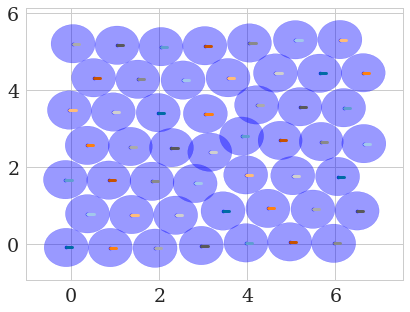

In [17]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -3]) # zero eigenvalue = translation in y

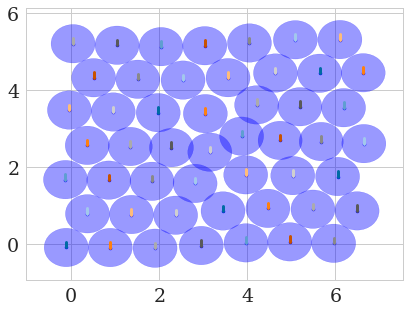

In [18]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -2]) # second zero eigenvalue = translation in x

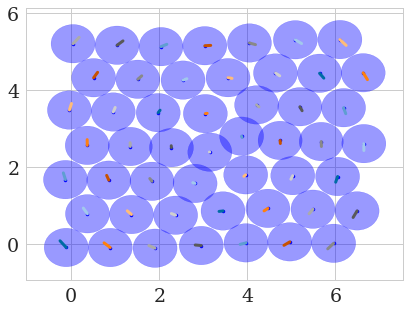

In [19]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -1]) # positive eigenvalue = rotation

Continue running the simulation to check if this state really is stable.

In [27]:
tf = 60.0
t_data = [0.0,tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = models_ef[force].simulate(history[-1], t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,50*dim, 50*dim), order='F')

-19.717064421234745
-19.717019260986504
-19.716945897862892
-19.716902156392237
-19.71683019510256
-19.716787836762922
-19.716717241933157
-19.716676231842296
-19.71660696900453
-19.716567273175915
-19.716499308761023
-19.71646089409626
-19.716394195415074
-19.71635702968403
-19.716291564905607
-19.71625561672425
-19.716191354853706
-19.71615659366232
-19.716093504519016
-19.716059900560506
-19.715997954756656
-19.715965479055384
-19.71590464797515
-19.715873272316493
-19.71581352809553
-19.71578322500554
-19.71572454051119
-19.715695283237043
-19.715637632048896
-19.715609394539726
-19.71555275093053
-19.715525507818796
-19.71546984673615
-19.715443573319344
-19.715388870367626
-19.71536354259049
-19.715309774013292
-19.715285368450616
-19.715232511113573
-19.7152090049532
-19.715157036327444
-19.71513440735392
-19.715083305499686
-19.715061532078142
-19.715011275629067
-19.71499033668966
-19.714940904837267
-19.71492077986006
-19.71487215233868
-19.7148528213387
-19.714804978411113
-

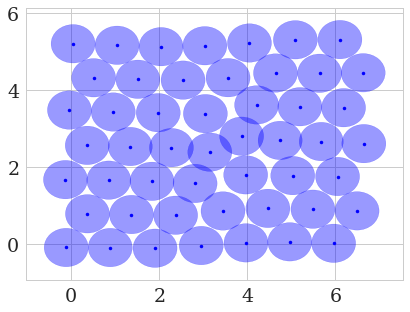

In [28]:
plot_population(history[-1])

In [29]:
eigenvalues_cubic[-1,:]

array([-1.36034542e+01, -9.88607396e+00, -9.26921429e+00, -9.01969214e+00,
       -7.77821167e+00, -7.67474532e+00, -7.53480689e+00, -7.46802496e+00,
       -7.12306670e+00, -6.95477920e+00, -6.92229339e+00, -6.80445242e+00,
       -6.77492640e+00, -6.59098160e+00, -6.52313040e+00, -6.45501197e+00,
       -6.37026434e+00, -6.20562657e+00, -5.99180011e+00, -5.97170552e+00,
       -5.82777808e+00, -5.67916348e+00, -5.66895399e+00, -5.55119723e+00,
       -5.42397620e+00, -5.18328540e+00, -5.04362158e+00, -4.98712630e+00,
       -4.85780033e+00, -4.84653766e+00, -4.74140044e+00, -4.58129543e+00,
       -4.47236404e+00, -4.28189210e+00, -4.19326696e+00, -4.11509193e+00,
       -4.08740875e+00, -3.94612806e+00, -3.88736015e+00, -3.73024962e+00,
       -3.53851458e+00, -3.49691962e+00, -3.37418499e+00, -3.23848272e+00,
       -3.20542052e+00, -3.11821757e+00, -2.99284673e+00, -2.95389386e+00,
       -2.78698685e+00, -2.74188175e+00, -2.67107557e+00, -2.61017317e+00,
       -2.58906012e+00, -

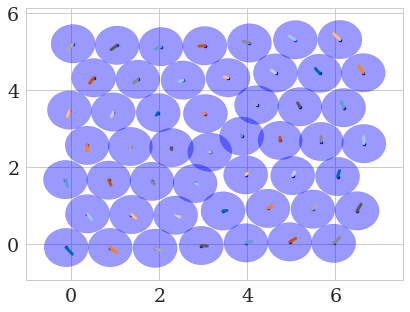

In [31]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_cubic[time_index, :, -3]) # positive eigenvalue = rotation

In [32]:
tf = 60.0
t_data = [0.0,tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
ts, history = models_ef[force].simulate(history[-1], t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')
eigenvectors_cubic = eigenvectors_cubic.reshape((-1,50*dim, 50*dim), order='F')

-19.71185021389673
-19.71186058594179
-19.711848673294206
-19.71185906047715
-19.711847162818188
-19.711857564840255
-19.71184568187301
-19.711856098440308
-19.711844229873797
-19.711854660698293
-19.71184280624737
-19.711853251046815
-19.711841410432147
-19.711851868930054
-19.71184004187788
-19.711850513803274
-19.71183870004541
-19.71184918513283
-19.711837384406454
-19.7118478823958
-19.711836094443445
-19.711846605079817
-19.71183482964915
-19.711845352682836
-19.711833589526684
-19.71184412471295
-19.71183237358904
-19.711842920688106
-19.711831181359088
-19.711841740136
-19.711830012369244
-19.711840582593805
-19.711828866161387
-19.711839447607964
-19.71182774228653
-19.71183833473402
-19.711826640304743
-19.71183724353647
-19.71182555978485
-19.71183617358855
-19.71182450030441
-19.711835124472028
-19.711823461449388
-19.71183409577702
-19.71182244281408
-19.711833087101923
-19.711821444000854
-19.711832098053087
-19.711820464620043
-19.711831128244803
-19.71181950428981
-19.7

In [33]:
eigenvalues_cubic[-1,:]

array([-1.36034428e+01, -9.88607211e+00, -9.26920188e+00, -9.01968130e+00,
       -7.77821286e+00, -7.67475583e+00, -7.53481157e+00, -7.46801318e+00,
       -7.12307357e+00, -6.95479258e+00, -6.92229372e+00, -6.80444246e+00,
       -6.77493281e+00, -6.59099742e+00, -6.52314365e+00, -6.45501504e+00,
       -6.37026484e+00, -6.20560856e+00, -5.99179400e+00, -5.97171249e+00,
       -5.82777571e+00, -5.67916085e+00, -5.66893867e+00, -5.55119486e+00,
       -5.42395913e+00, -5.18328393e+00, -5.04362927e+00, -4.98713022e+00,
       -4.85779532e+00, -4.84654401e+00, -4.74140313e+00, -4.58132752e+00,
       -4.47239116e+00, -4.28190000e+00, -4.19328949e+00, -4.11509422e+00,
       -4.08740462e+00, -3.94613013e+00, -3.88734864e+00, -3.73025803e+00,
       -3.53852457e+00, -3.49690973e+00, -3.37418359e+00, -3.23847587e+00,
       -3.20542556e+00, -3.11822485e+00, -2.99282737e+00, -2.95390335e+00,
       -2.78699075e+00, -2.74188162e+00, -2.67108161e+00, -2.61014194e+00,
       -2.58904368e+00, -

Looks like it is!

## PWQ force

In [9]:
force = 'pw. quad.'
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending[force]+'.txt')
eigenvectors_pwq = np.loadtxt('eigenvectors'+filename_ending[force]+'.txt')
eigenvectors_pwq = eigenvectors_pwq.reshape((-1,50*dim, 50*dim), order='F')


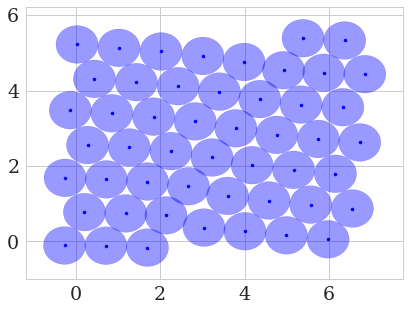

In [10]:
plot_population(history[-1])

In [23]:
np.count_nonzero(np.isclose(eigenvalues_pwq, 0, atol=0.00001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [24]:
np.count_nonzero(eigenvalues_pwq > 0.00001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [25]:
eigenvalues_pwq[-1,:]

array([-9.79012350e+00, -9.15204997e+00, -8.77868084e+00, -8.56844157e+00,
       -8.41929865e+00, -8.26757528e+00, -8.22179782e+00, -8.06254945e+00,
       -7.92877059e+00, -7.79032987e+00, -7.70867264e+00, -7.57587263e+00,
       -7.37161151e+00, -7.24346653e+00, -7.19788585e+00, -6.95941436e+00,
       -6.89404803e+00, -6.80386853e+00, -6.67401713e+00, -6.54657789e+00,
       -6.49787495e+00, -6.33049046e+00, -6.23143602e+00, -6.12753644e+00,
       -5.98989645e+00, -5.73624729e+00, -5.60711163e+00, -5.52414810e+00,
       -5.41980363e+00, -5.36636428e+00, -5.16008448e+00, -5.06104778e+00,
       -4.94265984e+00, -4.75078531e+00, -4.51437982e+00, -4.42012685e+00,
       -4.37149482e+00, -4.25952559e+00, -4.16557818e+00, -4.13358089e+00,
       -4.06230008e+00, -3.93687401e+00, -3.70064159e+00, -3.61650378e+00,
       -3.58730733e+00, -3.54467203e+00, -3.40264559e+00, -3.25486311e+00,
       -3.22833888e+00, -3.16279114e+00, -3.06602710e+00, -2.98185276e+00,
       -2.91679531e+00, -

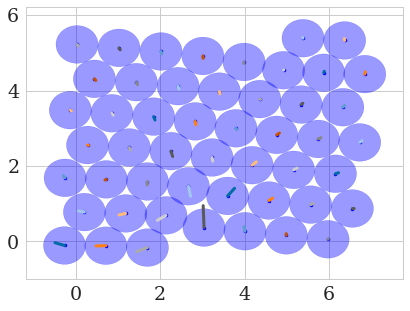

In [26]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_pwq[time_index, :, -1]) # zero eigenvalue = translation in y

In [11]:
new_init = history[-1]

In [13]:
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(new_init, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending[force]+'.txt')
eigenvectors_pwq = np.loadtxt('eigenvectors'+filename_ending[force]+'.txt')
eigenvectors_pwq = eigenvectors_pwq.reshape((-1,50*dim, 50*dim), order='F')


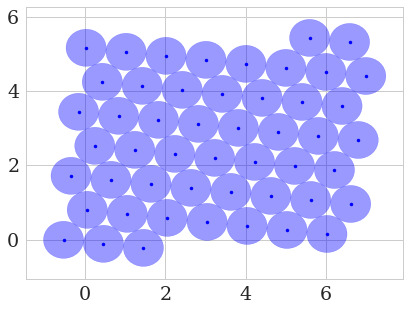

In [14]:
plot_population(history[-1])

In [15]:
eigenvalues_pwq[-1,:]

array([-8.57655424e+00, -8.51008320e+00, -8.41046011e+00, -8.21822563e+00,
       -8.06410773e+00, -7.98146988e+00, -7.89864098e+00, -7.84162779e+00,
       -7.70002428e+00, -7.56945340e+00, -7.54687975e+00, -7.38831922e+00,
       -7.29160845e+00, -7.14354925e+00, -7.13466151e+00, -7.06229293e+00,
       -6.96700203e+00, -6.88443662e+00, -6.84904457e+00, -6.72832104e+00,
       -6.60889521e+00, -6.41155119e+00, -6.30436683e+00, -6.13370534e+00,
       -5.83478245e+00, -5.67471384e+00, -5.62366383e+00, -5.57766338e+00,
       -5.29709786e+00, -5.22815576e+00, -5.10657085e+00, -5.03546419e+00,
       -4.94132687e+00, -4.63467639e+00, -4.51873753e+00, -4.50536476e+00,
       -4.41441442e+00, -4.27115591e+00, -4.08819602e+00, -4.04382831e+00,
       -3.99055171e+00, -3.90187489e+00, -3.80673990e+00, -3.71253502e+00,
       -3.59788592e+00, -3.49970637e+00, -3.37897487e+00, -3.25979260e+00,
       -3.18508463e+00, -3.16414582e+00, -3.11008198e+00, -3.02886973e+00,
       -2.99266696e+00, -

In [17]:
np.count_nonzero(eigenvalues_pwq > 0.0000001, axis=1) # positive eigenvalues

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

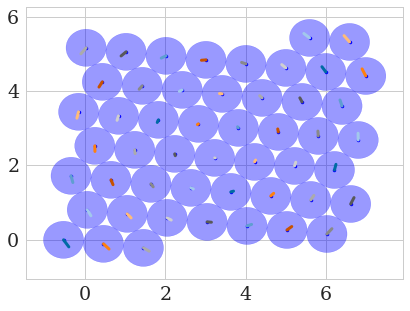

In [18]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_pwq[time_index, :, -1]) # zero eigenvalue = translation in y

Now there's only a single positive eigenvalue and its the rotational one. And it's getting smaller and smaller. So I guess Per was right. 

## GLS force

In [9]:
force = 'GLS'
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')
eigenvectors_gls = np.loadtxt('eigenvectors'+filename_ending['GLS']+'.txt')
eigenvectors_gls = eigenvectors_gls.reshape((-1,50*dim, 50*dim), order='F')


In [10]:
new_init = history[-1]

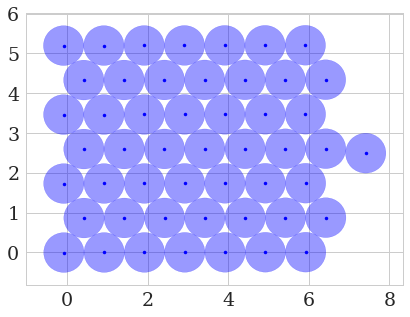

In [11]:
plot_population(new_init)

In [12]:
eigenvalues_gls[-1,:]

array([-1.10903434e+01, -1.10733395e+01, -1.09916431e+01, -1.06306552e+01,
       -1.04717390e+01, -1.04676055e+01, -1.01273204e+01, -1.00891842e+01,
       -1.00155696e+01, -9.82933235e+00, -9.77235504e+00, -9.57730203e+00,
       -9.43251503e+00, -9.38205705e+00, -9.30846767e+00, -9.21925114e+00,
       -9.08991437e+00, -8.94710945e+00, -8.83228107e+00, -8.75167976e+00,
       -8.50632826e+00, -8.30765729e+00, -8.17325299e+00, -7.91213097e+00,
       -7.66148709e+00, -7.36048779e+00, -7.26948773e+00, -7.18153272e+00,
       -7.08753642e+00, -7.02731716e+00, -6.82753392e+00, -6.37717498e+00,
       -6.33112588e+00, -6.06373956e+00, -6.02403282e+00, -5.74924134e+00,
       -5.64856858e+00, -5.48014540e+00, -5.37525574e+00, -5.26100089e+00,
       -5.17251711e+00, -4.90553985e+00, -4.82905792e+00, -4.73890522e+00,
       -4.69362505e+00, -4.50758183e+00, -4.48189826e+00, -4.25665899e+00,
       -4.16872264e+00, -4.15572093e+00, -4.11246906e+00, -4.03245488e+00,
       -3.79697514e+00, -

In [14]:
np.count_nonzero(np.isclose(eigenvalues_gls, 0, atol=0.0000001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
np.count_nonzero(eigenvalues_gls > 0.000001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [16]:
tf = 60.0
t_data = [0, tf]

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvalues'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('eigenvectors'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(new_init, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)

eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')
eigenvectors_gls = np.loadtxt('eigenvectors'+filename_ending['GLS']+'.txt')
eigenvectors_gls = eigenvectors_gls.reshape((-1,50*dim, 50*dim), order='F')


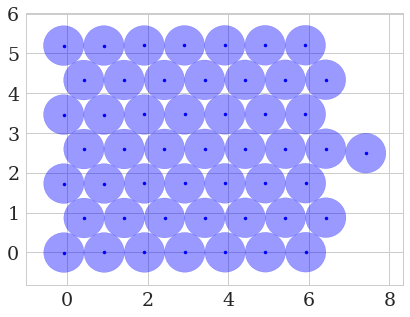

In [17]:
plot_population(history[-1])

In [21]:
np.count_nonzero(np.isclose(eigenvalues_gls, 0, atol=0.0000000001), axis=1) # zero eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [26]:
np.count_nonzero(eigenvalues_gls > 0.000000001, axis=1) # positive eigenvalues

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
eigenvalues_gls[-1,:]

array([-1.10915181e+01, -1.10753795e+01, -1.09950912e+01, -1.06342059e+01,
       -1.04721138e+01, -1.04700541e+01, -1.01306114e+01, -1.00906693e+01,
       -1.00174760e+01, -9.83060548e+00, -9.77560668e+00, -9.57869426e+00,
       -9.43496523e+00, -9.38314318e+00, -9.31110645e+00, -9.22045192e+00,
       -9.09319624e+00, -8.94792135e+00, -8.83322758e+00, -8.75421935e+00,
       -8.50648710e+00, -8.31029991e+00, -8.17497241e+00, -7.91427938e+00,
       -7.66270630e+00, -7.36286318e+00, -7.27044958e+00, -7.18349609e+00,
       -7.08797187e+00, -7.02836663e+00, -6.82888608e+00, -6.37883731e+00,
       -6.33213918e+00, -6.06466230e+00, -6.02438391e+00, -5.75007423e+00,
       -5.64916555e+00, -5.48141415e+00, -5.37633060e+00, -5.26228889e+00,
       -5.17316552e+00, -4.90585908e+00, -4.82998765e+00, -4.74010995e+00,
       -4.69483114e+00, -4.50848798e+00, -4.48278799e+00, -4.25744115e+00,
       -4.16941337e+00, -4.15635774e+00, -4.11315837e+00, -4.03336344e+00,
       -3.79851187e+00, -

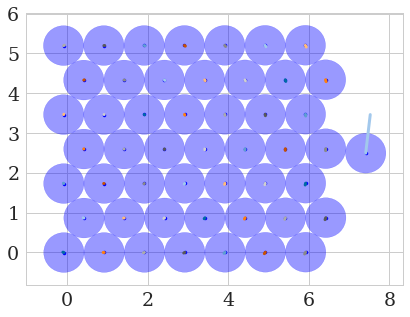

In [28]:
time_index = -1
plot_eigenvector_on_population(history[time_index], eigenvectors_gls[time_index, :, -4]) # zero eigenvalue = translation in y

In [29]:
eigenvalues_gls[time_index, :]

array([-1.10915181e+01, -1.10753795e+01, -1.09950912e+01, -1.06342059e+01,
       -1.04721138e+01, -1.04700541e+01, -1.01306114e+01, -1.00906693e+01,
       -1.00174760e+01, -9.83060548e+00, -9.77560668e+00, -9.57869426e+00,
       -9.43496523e+00, -9.38314318e+00, -9.31110645e+00, -9.22045192e+00,
       -9.09319624e+00, -8.94792135e+00, -8.83322758e+00, -8.75421935e+00,
       -8.50648710e+00, -8.31029991e+00, -8.17497241e+00, -7.91427938e+00,
       -7.66270630e+00, -7.36286318e+00, -7.27044958e+00, -7.18349609e+00,
       -7.08797187e+00, -7.02836663e+00, -6.82888608e+00, -6.37883731e+00,
       -6.33213918e+00, -6.06466230e+00, -6.02438391e+00, -5.75007423e+00,
       -5.64916555e+00, -5.48141415e+00, -5.37633060e+00, -5.26228889e+00,
       -5.17316552e+00, -4.90585908e+00, -4.82998765e+00, -4.74010995e+00,
       -4.69483114e+00, -4.50848798e+00, -4.48278799e+00, -4.25744115e+00,
       -4.16941337e+00, -4.15635774e+00, -4.11315837e+00, -4.03336344e+00,
       -3.79851187e+00, -